In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!ls "/content/drive/Shared with me/Cogs 118b Final Project"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prep Data

In [4]:
def create_dataframe(datapath):
  newsdf = pd.read_csv(datapath)
  return newsdf

In [5]:
# A function to prepare the dataset, given a list of strings for each feature
# Optional features - compound, pos, neg, neu, num words, num characters
def prep_data(newsdf, feature_list): 
  data = []
  for feature in feature_list:
      data.append(np.array(newsdf.get(feature)))
  formatted_data = np.array(data).T
  return formatted_data

# Global Variables

In [6]:
datapath = "df_labeled.csv"
newsdf = create_dataframe(datapath)

In [7]:
label_feature = 'label'
compound_feature = 'compound'
num_words_feature = 'num words'
num_chars_feature = 'num characters'
pos_feature = 'pos'
neg_feature = 'neg'
neu_feature = 'neu'
labels = np.array(newsdf.get('label'))
RANDOM_STATE = 42

## Incorporate TF-IDF into data

In [8]:
#import natural language toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.probability import FreqDist
import string

# get lexicon 
nltk.download('vader_lexicon') 
nltk.download('punkt')
nltk.download('stopwords')

analyser = SentimentIntensityAnalyzer()

## import word tokenizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', max_features = 2000, tokenizer = word_tokenize, 
                             stop_words = stopwords.words('english'))
newsdf = newsdf.dropna(subset=['title'])
newsdf = newsdf[newsdf.title != '']
X = vectorizer.fit_transform(newsdf['title']).toarray()
y = newsdf['label'].to_numpy()
tfidf = TfidfVectorizer(sublinear_tf = True, analyzer = 'word', max_features = 2000, tokenizer = word_tokenize)
tfidf_X = tfidf.fit_transform(newsdf['title']).toarray()
tfidf_X

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.35842266, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [10]:
tfidf_X.shape

(44889, 2000)

# Split Data

In [11]:
XFeatures = prep_data(newsdf, ['compound', 'pos', 'neg', 'neu', 'num words', 'num characters'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(XFeatures, y, train_size=0.8, random_state=RANDOM_STATE, shuffle=True)

In [13]:
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(tfidf_X, y, train_size=0.8, random_state=RANDOM_STATE, shuffle=True)

In [14]:
tfidf_X_train.shape

(35911, 2000)

# Testing PCA

In [15]:
pca = PCA(n_components=300).fit(tfidf_X)
tfidf_X_pca = pca.transform(tfidf_X)

In [16]:
tfidf_X_pca_train, tfidf_X_pca_test, tfidf_y_pca_train, tfidf_y_pca_test = train_test_split(tfidf_X_pca, y, train_size=0.8, random_state=RANDOM_STATE, shuffle=True)

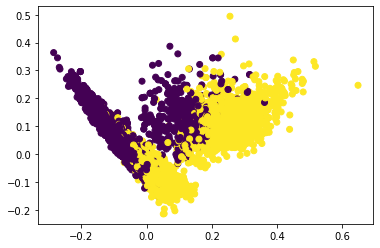

In [17]:
plt.scatter(tfidf_X_pca_train[:,0], tfidf_X_pca_train[:,1], c=tfidf_y_pca_train)
plt.show()

In [18]:
tfidf_X_pca.shape

(44889, 300)

In [19]:
# Code to explore 2D plots within the 100D space of 'data_pca', looking for good k-means application space (2 distinct blobs)
# WARNING -- takes forever lol
def plot_with_100_features_PCA(data_pca):
  for i in np.arange(30,31):
      for j in np.arange(99):
          print('first dim is ',i, '& second dim is ',j)
          plt.scatter(data_pca[:,i], data_pca[:,j], c=labels)
          plt.show()

# SKLearn KMeans Results

In [20]:
def sklearn_kmeans(data, n_clusters, feature_list):
  newsdfdata = prep_data(newsdf, feature_list)
  kmeans = KMeans(n_clusters=2, random_state=0).fit(newsdfdata)
  return kmeans

# Our Own Implementation of KMeans

In [21]:
def calcSqDistances(X, Kmus):
    return ((-2 * X.dot(Kmus.T) + np.sum(Kmus*Kmus, axis=1).T).T + np.sum(X*X, axis=1)).T

In [22]:
def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis=1)
    return np.eye(sqDmat.shape[1])[m]

In [23]:
def recalcMus(X, Rnk):
    return (np.divide(X.T.dot(Rnk), np.sum(Rnk, axis=0))).T

In [24]:
def runKMeans(K, X, plotdim='2D'):
    
    # Determine and store data set information
    N = np.shape(X)[0]
    D = np.shape(X)[1]

    # Allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    # Initialize cluster centers by randomly picking points from the data
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];

    # Specify the maximum number of iterations to allow
    maxiters = 1000;

    for iter in range(maxiters):
        # Assign each data vector to closest mu vector as per Bishop (9.2)
        # Do this by first calculating a squared distance matrix where the n,k entry
        # contains the squared distance from the nth data vector to the kth mu vector

        # sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus);

        # given the matrix of squared distances, determine the closest cluster center for each data vector 

        # R is the "responsibility" matrix
        # R will be an N-by-K matrix of binary values whose n,k entry is set as per Bishop (9.2)
        # Specifically, the n,k entry is 1 if point n is closest to cluster k, and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        #plotCurrent(X, Rnk, Kmus, dim=plotdim)
        plt.show()

        # Recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)

        # Check to see if the cluster centers have converged.  If so, break.
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break

    return plotCurrent(X,Rnk,Kmus, dim=plotdim)

In [25]:
def plotCurrent(X, Rnk, Kmus, dim):
    N, D = np.shape(X)
    K = np.shape(Kmus)[0]

    InitColorMat = np.matrix([[1, 0, 0], 
                              [0, 1, 0],   
                              [0, 0, 1],
                              [0, 0, 0],
                              [1, 1, 0], 
                              [1, 0, 1], 
                              [0, 1, 1]])

    KColorMat = InitColorMat[0:K]
    colorVec = Rnk.dot(KColorMat)
    muColorVec = np.eye(K).dot(KColorMat)

    if dim=='2D':
        plt.scatter(X[:,0], X[:,1], edgecolors=colorVec, facecolors='none', alpha=0.3)
        plt.scatter(Kmus[:,0], Kmus[:,1], c=muColorVec, marker='D', s=50)
   
    else: #plot 3d
        fig = plt.figure(figsize=(5,5))
        ax0 = fig.add_subplot(projection='3d')
        ax0.scatter(X[:,0], X[:,1], X[:,2], c=colorVec) 
    
    return np.array(colorVec)[:,0]

# Helper Functions

In [26]:
def convertToDF(X):
  df = pd.DataFrame(X)
  return df

In [27]:
def convertToNPArray(df):
  arr = df.to_numpy(X)
  return arr

In [28]:
# A function to check what % of the labels were grouped correctly - works for 2d and 3d
def check_acc(km_labels, real_labels):
    same_order = np.sum(km_labels == labels) / len(labels)
    # because of the nature of clustering, the actual naming of the two groups doesn't need to match exactly
    diff_order = np.sum(km_labels != labels) / len(labels)
    acc_fraction = max(same_order, diff_order) 
    print('The accuracy fraction is: ',acc_fraction)
    return acc_fraction

In [29]:
# A function to plot the real labels in 3d (for comparison to the k-means plot)
def plot_real_labels(data, labels, angle1=0, angle2=0, title='3d real labels', xlbl='x', ylbl='y', flip=True):
    if flip:   #because the groups may be named differently, this variable 'flips' all bits so the colors match
      labels=1-labels
    fig = plt.figure(figsize=(5,5))
    ax0 = fig.add_subplot(projection='3d')
    ax0.scatter(data[:,0], data[:,1], data[:,2], c=labels)
    #ax0.view_init(angle1, angle2)
    ax0.set_title(title) 
    ax0.set_xlabel(xlbl)
    ax0.set_ylabel(ylbl)

# Test KMeans - Our Own Implementation

In [30]:
# data = prep_data(newsdf, [neg_feature, compound_feature, num_words_feature])
# plot_real_labels(data, labels)
# km_labels = runKMeans(2, data, plotdim='3D')
# km_labels = runKMeans(2, data, plotdim='2D')
# data44 = prep_data(newsdf, [neg_feature, num_words_feature, num_chars_feature, pos_feature])
# km_labels = runKMeans(2, data, plotdim='2D')
# check_acc(km_labels, labels)

In [31]:
#data2 = createDataWith3Features(neg_feature, sentiment_feature, num_words_feature)
# tfidfValues = data_pca[:, 0]
# data100 = np.array([compound_feature, tfidfValues]).T  

In [32]:
#data44 = np.array([data2D]).T
# km_labels = runKMeans(2, data_pca, plotdim='2D')
# check_acc(km_labels, labels)

# Test KMeans - SKLearn

In [33]:
kmeans = KMeans(2, random_state=0).fit(tfidf_X_train)
km_labels = kmeans.labels_

In [34]:
accuracy_score(km_labels, tfidf_y_train)

0.6070563337139038

In [35]:
# tfidfValues = data_pca[:, 2]
# data = []
# compound = np.array(newsdf.get('compound'))
# data.append(compound)
# data.append(data_pca)
# kmeans = KMeans(2, random_state=0).fit(data_pca)
# km_labels = kmeans.labels_
# check_acc(km_labels, labels)
# plt.scatter(compound, tfidfValues, c=labels)

In [36]:
# data = prep_data(newsdf, [sentiment_feature, num_words_feature])
# #plot_real_labels(data, labels)
# #km_labels = runKMeans(2, data, plotdim='3D')
# #km_labels = runKMeans(2, data, plotdim='2D')
# kmeans = KMeans(2, random_state=0).fit(data)
# km_labels = kmeans.labels_
# check_acc(km_labels, labels)
# plt.scatter(compound, tfidfValues, c=labels)

In [37]:
def bestFeaturesNoTFIDF(newsdf, labels, dim):
  feature_list = [compound_feature, num_words_feature, num_chars_feature, pos_feature, neg_feature, neu_feature]
  df = pd.DataFrame() 
  
  if dim == '2D':
    for feature1 in feature_list:
      char_feature_list = ''
      data = []
      for feature2 in feature_list:
        if (feature1 == feature2):
          continue
        else:
          data = prep_data(newsdf, [feature1, feature2])
          char_feature_list = feature1 + feature2
          kmeans = KMeans(2, random_state=0).fit(data)
          km_labels = kmeans.labels_
          accuracy = accuracy_score(km_labels, labels)
          new_row = {'featurenames':char_feature_list, 'accuracies':accuracy}
          df = df.append(new_row, ignore_index=True)
  else:
    for feature1 in feature_list:
      char_feature_list = ''
      data = []
      for feature2 in feature_list:
        for feature3 in feature_list:
            data = prep_data(newsdf, [feature1, feature2, feature3])
            char_feature_list = feature1 + feature2 + feature3
            kmeans = KMeans(2, random_state=0).fit(data)
            km_labels = kmeans.labels_
            accuracy = accuracy_score(km_labels, labels)
            new_row = {'featurenames':char_feature_list, 'accuracies':accuracy}
            df = df.append(new_row, ignore_index=True)
  return df

In [38]:
def bestNforPCA(data):
  df = pd.DataFrame() 
  numRows, numCols = np.shape(data)
  for i in range (100, numCols+1, 100):
    pca = PCA(n_components=i).fit(data)
    tfidf_X_pca = pca.transform(data)
    tfidf_X_pca_train, tfidf_X_pca_test, tfidf_y_pca_train, tfidf_y_pca_test = train_test_split(tfidf_X_pca, y, train_size=0.8, random_state=RANDOM_STATE, shuffle=True)
    kmeans = KMeans(2, random_state=0).fit(tfidf_X_pca_train)  
    km_labels = kmeans.labels_
    accuracy = accuracy_score(km_labels, tfidf_y_pca_train)
    new_row = {'N Value PCA':i, 'accuracies':accuracy}
    df = df.append(new_row, ignore_index=True)
  return df

In [39]:
# tfidfValues = data_pca[:, 2]
# data = []
# compound = np.array(newsdf.get('compound'))
# pos = np.array(newsdf.get('pos'))
# neg = np.array(newsdf.get('neg'))
# data.append(compound)
# data.append(pos)
# data.append(neg)
# kmeans = KMeans(2, random_state=0).fit(data)
# km_labels = kmeans.labels_
# check_acc(km_labels, labels)
# plt.scatter(data[1], data[0], data[2], c=labels)

In [40]:
tfidf_X_train_df = convertToDF(tfidf_X_train)
tfidf_y_train_df = convertToDF(tfidf_y_train)
X_train_DF = convertToDF(X_train)
y_train_DF = convertToDF(y_train)

In [41]:
bestFeaturesDF2D = bestFeaturesNoTFIDF(newsdf, newsdf['label'], '2D')

In [42]:
bestFeaturesDF2D

,accuracies,featurenames
0,0.698278,compoundnum words
1,0.361737,compoundnum characters
2,0.594555,compoundpos
3,0.594956,compoundneg
4,0.595201,compoundneu
5,0.698278,num wordscompound
6,0.648867,num wordsnum characters
7,0.301722,num wordspos
8,0.301722,num wordsneg
9,0.301722,num wordsneu


In [43]:
X_train_DF = pd.DataFrame(X_train, columns=['compound', 'pos', 'neg', 'neu', 'num words', 'num characters'])
y_train_DF = pd.DataFrame(y_train, columns=['label'])

In [44]:
X_train_DF

,compound,pos,neg,neu,num words,num characters
0,-0.5267,0.000,0.207,0.793,14.0,72.0
1,0.2808,0.174,0.117,0.709,18.0,86.0
2,0.0000,0.000,0.000,1.000,14.0,75.0
3,-0.4824,0.000,0.148,0.852,19.0,85.0
4,-0.8442,0.000,0.431,0.569,15.0,81.0
...,...,...,...,...,...,...
35906,-0.4767,0.000,0.220,0.780,12.0,69.0
35907,0.0000,0.000,0.000,1.000,9.0,55.0
35908,-0.4767,0.000,0.193,0.807,14.0,78.0
35909,-0.6597,0.000,0.278,0.722,16.0,80.0


In [45]:
y_train_DF

,label
0,0
1,0
2,1
3,0
4,0
...,...
35906,0
35907,1
35908,1
35909,0


In [46]:
bestFeaturesDF2D = bestFeaturesNoTFIDF(X_train_DF, y_train_DF, '2D')

In [47]:
bestFeaturesDF2D

,accuracies,featurenames
0,0.299602,compoundnum words
1,0.360085,compoundnum characters
2,0.406143,compoundpos
3,0.405419,compoundneg
4,0.404806,compoundneu
5,0.299602,num wordscompound
6,0.349419,num wordsnum characters
7,0.248949,num wordspos
8,0.299602,num wordsneg
9,0.299602,num wordsneu


In [48]:
bestFeaturesDF2D.to_csv(r'C:\Users\ksang\Desktop\BestFeatures2D.csv', index = False)

In [49]:
bestFeaturesDF3D = bestFeaturesNoTFIDF(X_train_DF, y_train_DF, '3D')

In [50]:
bestFeaturesDF3D

,accuracies,featurenames
0,0.404472,compoundcompoundcompound
1,0.299602,compoundcompoundnum words
2,0.360085,compoundcompoundnum characters
3,0.405168,compoundcompoundpos
4,0.405113,compoundcompoundneg
...,...,...
211,0.299602,neuneunum words
212,0.360085,neuneunum characters
213,0.533430,neuneupos
214,0.448386,neuneuneg


In [51]:
bestFeaturesDF3D['Model ID'] = range(0, 216)
bestFeaturesDF3D

,accuracies,featurenames,Model ID
0,0.404472,compoundcompoundcompound,0
1,0.299602,compoundcompoundnum words,1
2,0.360085,compoundcompoundnum characters,2
3,0.405168,compoundcompoundpos,3
4,0.405113,compoundcompoundneg,4
...,...,...,...
211,0.299602,neuneunum words,211
212,0.360085,neuneunum characters,212
213,0.533430,neuneupos,213
214,0.448386,neuneuneg,214


Text(0.5, 1.0, '2D Feature Combinations: Model ID vs. Accuracy')

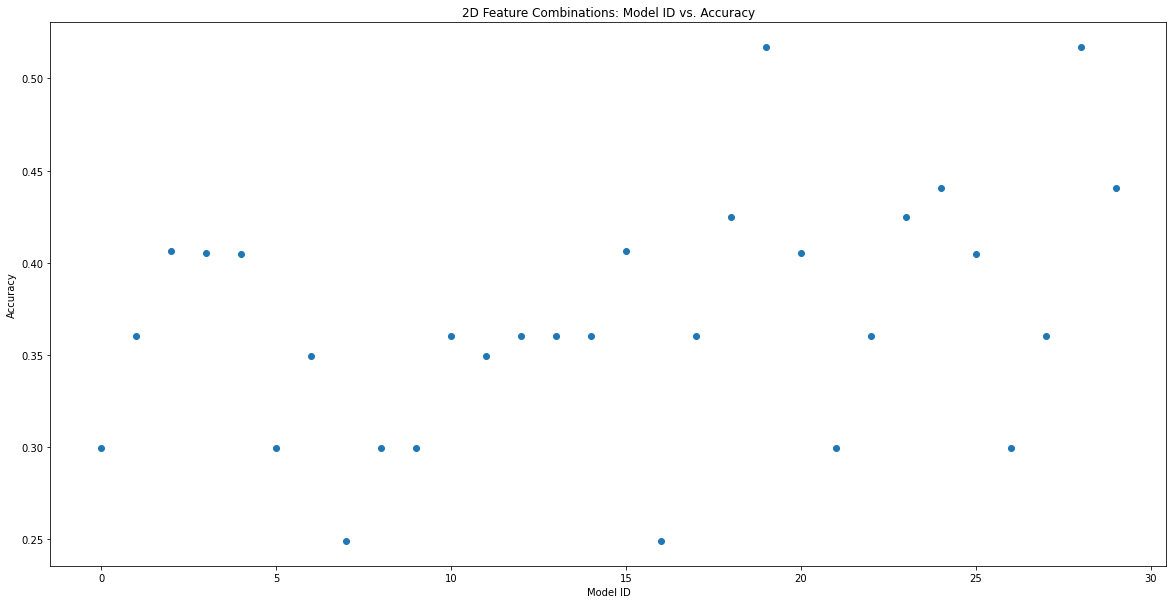

In [52]:
bestFeaturesDF2D['Model ID'] = range(0, 30)
plt.figure(figsize=(20, 10))
plt.scatter(bestFeaturesDF2D['Model ID'], bestFeaturesDF2D['accuracies'])
plt.xlabel("Model ID")
plt.ylabel("Accuracy")
plt.title("2D Feature Combinations: Model ID vs. Accuracy")

In [53]:

bestFeaturesDF3D.to_csv(r'C:\Users\ksang\Desktop\Again-BestFeatures3D.csv', index = False)

Text(0.5, 1.0, '3D Feature Combinations: Model ID vs. Accuracy')

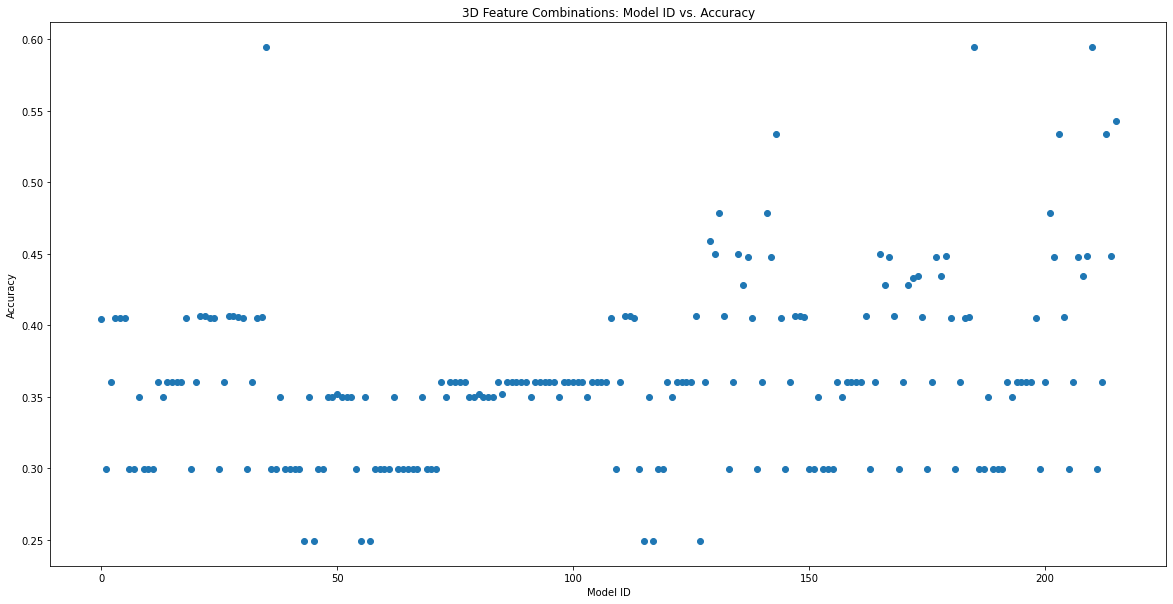

In [54]:
plt.figure(figsize=(20, 10))
plt.scatter(bestFeaturesDF3D['Model ID'], bestFeaturesDF3D['accuracies'])
plt.xlabel("Model ID")
plt.ylabel("Accuracy")
plt.title("3D Feature Combinations: Model ID vs. Accuracy")

In [55]:
# bestFeaturesDF3D = bestFeaturesNoTFIDF(newsdf, labels, '3D')

In [56]:
# bestFeaturesDF3D['Model ID'] = range(0, 216)
# bestFeaturesDF3D

In [57]:
# plt.scatter(bestFeaturesDF3D['Model ID'], bestFeaturesDF3D['accuracies'])

In [58]:
# bestFeaturesDF3D.to_csv(r'C:\Users\ksang\Desktop\AttemptBestFeatures3DCOGS118BFinal', index = False)

In [59]:

#dfBestNPCA = bestNforPCA(tfidf_X)
#dfBestNPCA

In [60]:
tfidf_y_pca_train.shape

(35911,)

In [61]:
tfidf_X_pca.shape

(44889, 300)

In [62]:
kmeans = KMeans(2, random_state=0).fit(tfidf_X_pca_train)
km_labels_pca = kmeans.labels_

In [63]:
y_pred = kmeans.predict(tfidf_X_pca_train)

In [64]:
accuracy_score(y_pred, tfidf_y_pca_train)

0.39297151290690874

Text(0, 0.5, 'Principal Component 2')

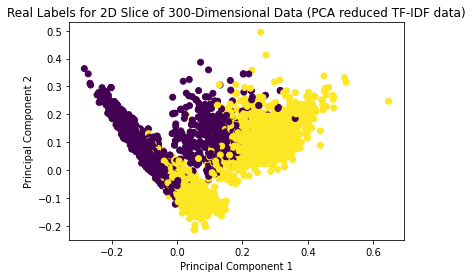

In [65]:
#tfidf_y_train = np.concatenate(tfidf_y_pca_train,tfidf_y_pca_test)
plt.scatter(tfidf_X_pca_train[:,0], tfidf_X_pca_train[:,1], c=tfidf_y_pca_train)
plt.title("Real Labels for 2D Slice of 300-Dimensional Data (PCA reduced TF-IDF data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Text(0, 0.5, 'Principal Component 2')

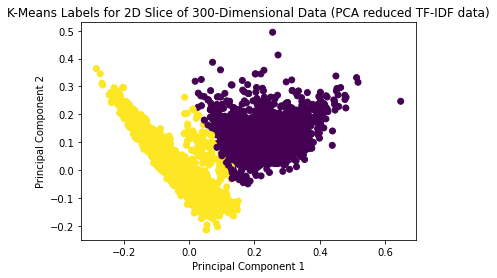

In [66]:
#tfidf_y_train = np.concatenate(tfidf_y_pca_train,tfidf_y_pca_test)
plt.scatter(tfidf_X_pca_train[:,0], tfidf_X_pca_train[:,1], c=km_labels_pca)
plt.title("K-Means Labels for 2D Slice of 300-Dimensional Data (PCA reduced TF-IDF data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Text(0, 0.5, 'Principal Component 151')

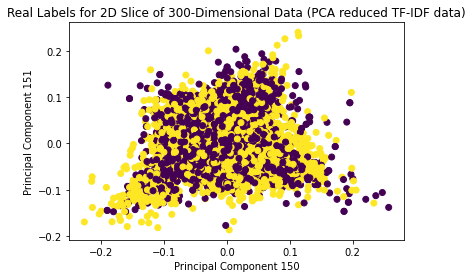

In [67]:
#tfidf_y_train = np.concatenate(tfidf_y_pca_train,tfidf_y_pca_test)
plt.scatter(tfidf_X_pca_train[:,151], tfidf_X_pca_train[:,152], c=tfidf_y_pca_train)
plt.title("Real Labels for 2D Slice of 300-Dimensional Data (PCA reduced TF-IDF data)")
plt.xlabel("Principal Component 150")
plt.ylabel("Principal Component 151")

Text(0, 0.5, 'Principal Component 151')

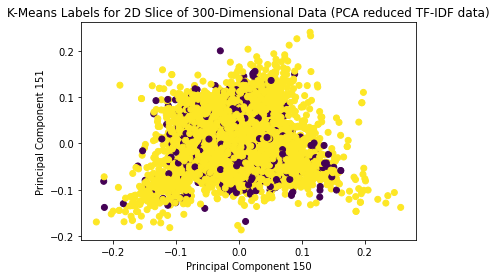

In [68]:
#tfidf_y_train = np.concatenate(tfidf_y_pca_train,tfidf_y_pca_test)
plt.scatter(tfidf_X_pca_train[:,151], tfidf_X_pca_train[:,152], c=km_labels_pca)
plt.title("K-Means Labels for 2D Slice of 300-Dimensional Data (PCA reduced TF-IDF data)")
plt.xlabel("Principal Component 150")
plt.ylabel("Principal Component 151")

# Em - Generate 3D Plots

In [70]:
# data = bigdata
# Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, train_size=0.8, random_state=42, shuffle=True)
# plot_real_labels(Xtrain, ytrain, title="Real Labels: 3D Slice of 6D Sentiment Features", xlbl='Compound Sentiment', ylbl='Positive Sentiment')
# plt.show()
# km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
# print('shapes',km_labels.shape,ytrain.shape)
# plot_real_labels(Xtrain, km_labels, title="KMeans Labels: 3D Slice of 6D Sentiment Features (65%)", xlbl='Compound Sentiment', ylbl='Positive Sentiment', flip=False)
# plt.show()

# data = data8
# Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, train_size=0.8, random_state=42, shuffle=True)
# plot_real_labels(Xtrain, ytrain, title="Real Labels: Shortened Sentiment Features", xlbl='Negative Sentiment', ylbl='Compound Sentiment')
# plt.show()
# km_labels = KMeans(2, random_state=12).fit(Xtrain).labels_
# plot_real_labels(Xtrain, km_labels, title="KMeans Labels: Shortened Sentiment Features (75%)", xlbl='Negative Sentiment', ylbl='Compound Sentiment', flip=False)
# plt.show()

# data = tfidf_X
# Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, train_size=0.8, random_state=42, shuffle=True)
# plot_real_labels(Xtrain,ytrain, title="Real Labels: 3D Slice of 2000D TF-IDF Data", xlbl='TF-IDF Axis 1', ylbl='TF-IDF Axis 2')
# plt.show()
# km_labels = KMeans(2, random_state=40).fit(Xtrain).labels_
# plot_real_labels(Xtrain, km_labels, title="KMeans Labels: 3D Slice of 2000D TF-IDF Data (86%)", xlbl='TF-IDF Axis 1', ylbl='TF-IDF Axis 2')
# plt.show()

# data = data_pca
# Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, train_size=0.8, random_state=42, shuffle=True)
# plot_real_labels(Xtrain, ytrain, title="Real Labels: 3D Slice of 2000D TF-IDF Data", xlbl='PCA TF-IDF Axis 1', ylbl='PCA TF-IDF Axis 2')
# plt.show()
# km_labels = KMeans(2, random_state=40).fit(Xtrain).labels_
# plot_real_labels(Xtrain, km_labels, title="KMeans Labels: 3D Slice of 2000D TF-IDF Data (86%)", xlbl='PCA TF-IDF Axis 1', ylbl='PCA TF-IDF Axis 2', flip=False)
# plt.show()
